<a href="https://colab.research.google.com/github/shubham2279/Routing/blob/main/Routing_Preliminary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
plt.rcParams['figure.dpi'] = 90
plt.rcParams.update({'font.size': 12})

In [52]:
#define the shape of the environment (i.e., its states)
environment_rows = 10
environment_columns = 10
initial_node_energy = .7  # the initial energy of each node in the network
number_of_episodes = 1000
transmission_energy_cost = 0.007  # the amount of energy(mJ) consumed by a node to receive and forward a packet to 1 hop distance
active_mode_energy_cost = 0.0005  # the amount of energy(mj) cosumed by a node for being in active mode
sleep_mode_energy_cost = 0.00025  # the amount of energy(mj) cosumed by a node for being in sleep mode

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a)
#The array contains 10 rows and 10 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions).
#The value of each (state, action) pair is initialized to 0.
q_values1 = np.zeros((environment_rows, environment_columns, 4))
q_values2 = np.zeros((environment_rows, environment_columns, 4))
q_values3 = np.zeros((environment_rows, environment_columns, 4))
q_values4 = np.zeros((environment_rows, environment_columns, 4))

#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']


#Define the environment and its functions
class WSN():
  def __init__(self, Q = None):
    self.Q = Q
    self.malicious = {} #store locations in a dictionary

  #define a function that simulate the function of SDN and control the behaviour of nodes
  def get_reward(self,row, column):
    #Create a 2D numpy array to hold the rewards for each state.
    #The array contains 10 rows and 10 columns (to match the shape of the environment), and each value is initialized to -1.
    delivery_rewards = np.full((environment_rows, environment_columns), 0.0)
    delivery_rewards[9, 9] = 1.0 #set the reward for the destination node (i.e., the goal) to 1

    #define malicious node(8 nodes) locations for rows 0 through 9
    # malicious = {} #store locations in a dictionary
    self.malicious[0] = []
    self.malicious[1] = [5]
    self.malicious[2] = [1]
    self.malicious[3] = [2]
    self.malicious[4] = [3]
    self.malicious[5] = [4]
    self.malicious[6] = [5]
    self.malicious[7] = [8]
    self.malicious[8] = [3]
    self.malicious[9] = []

    # malicious[1] = [3,5]
    # malicious[2] = [1,6]
    # malicious[3] = [2,5]
    # malicious[4] = [3,6]
    # malicious[5] = [2]
    # malicious[6] = [5,7]
    # malicious[7] = [7,8]
    # malicious[8] = [1,3]

    # #set the rewards for all maicious node
    # for row_index in range(1, 9):
    #   for column_index in malicious[row_index]:
    #     rewards[row_index, column_index] = -2.

    return delivery_rewards[row, column]

  #define a function that determines if the specified location is a terminal state(either a malicious node or the destination node)
  def is_terminal_state(self, current_row_index, current_column_index):
    #if the reward for this location is 1 (sink node) or if it's a malicious node, then it is a terminal state
    if self.get_reward(current_row_index, current_column_index) == 1.0:
      # print("SINK NODE REACHED")
      return True
    elif self.malicious[current_row_index]==current_column_index:
      # print("MALICIOUS NODE REACHED")
      return True
    else:
      return False

  #define a function that will choose a random, non-terminal starting location
  def get_starting_location(self):
    #get a random row and column index
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
    #continue choosing random row and column indexes until a non-terminal state is identified
    #(i.e., until the chosen state is a 'normal node').
    while self.is_terminal_state(current_row_index, current_column_index):
      current_row_index = np.random.randint(environment_rows)
      current_column_index = np.random.randint(environment_columns)
    return current_row_index, current_column_index

  #define an epsilon greedy algorithm that will choose which action to take next
  def get_next_action(self, current_row_index, current_column_index, epsilon):
    if np.random.random() > epsilon:
      return np.argmax(self.Q[current_row_index, current_column_index])
    else: #choose a random action
      return np.random.randint(4)

  #define a function that will get the next location based on the chosen action
  def get_next_location(self, current_row_index, current_column_index, action_index):
    new_row_index = current_row_index
    new_column_index = current_column_index
    if actions[action_index] == 'up' and current_row_index > 0:
      new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
      new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
      new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
      new_column_index -= 1
    return new_row_index, new_column_index

In [53]:
# Proposed Q-learning algorithm
def Proposed_Q_learning(epsilone = 0.9, discount_factor = 0.9, learning_rate = 0.9, alpha = 0.95):
    env = WSN(Q=q_values1)

    packet_delivery = []
    t_energy = []
    alive = []
    lifetime = []
    total_network_lifetime = 0

    path_lenght = 0
    nb_success = 0
    total_energy = 0

    # define the initial energy of nodes
    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)

    #run through 1000 training episodes
    for episode in range(number_of_episodes):
      print(episode)
      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()

      #initialize the amount of consumed energy to zero for the curretn episode
      energy = 0
      path_lenght = 0
      alive_node = environment_rows * environment_columns

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until the data packet reaches the destination node or stuck wiht a malicious node)
      while not env.is_terminal_state(row_index, column_index):
          # print("Row = ", row_index, "Column = ", column_index)
          #choose which action to take (i.e., where to move next)
          action_index = env.get_next_action(row_index, column_index, epsilone)


          #perform the chosen action, and transition to the next state (i.e., move to the next node)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)

          #receive the reward from SDN for moving to the new state
          delivery_reward = env.get_reward(row_index, column_index)
          temp_energy = transmission_energy_cost + 100 * active_mode_energy_cost

          reward = alpha*delivery_reward - (1-alpha)*temp_energy
          old_q_value = q_values1[old_row_index, old_column_index, action_index]
          temporal_difference = reward + (discount_factor * np.max(q_values1[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values1[old_row_index, old_column_index, action_index] = new_q_value

          #calculate the current energy-level for all nodes
          initial_energy -= active_mode_energy_cost
          initial_energy[old_row_index, old_column_index] -= transmission_energy_cost


           # add one step to path lenght
          path_lenght += 1
          total_network_lifetime += 1

          # if the energy level of any node is zero or less, it means that the node is died
          for row in range(environment_rows):
            for column in range(environment_columns):
              if initial_energy[row, column] <= 0:
                lifetime.append(total_network_lifetime)

          #if the nergy level of a node is zero or less, it means that node is died
          if initial_energy[row_index, column_index] <= 0:
              alive_node -= 1


          # If we have a reward, it means that our outcome is a success
          if delivery_reward == 1:
              nb_success += 1

      alive.append(alive_node)
      packet_delivery.append(nb_success/(episode+1))
      energy = path_lenght*transmission_energy_cost + 100 * path_lenght * active_mode_energy_cost
      total_energy += energy
      t_energy.append(total_energy)

    if len(lifetime) == 0:
      lifetime.append(1000)

    life = []
    for x in range(number_of_episodes):
      life.append(x)

    print('Q-learning Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / episode)
    print("Energy : ", total_energy)
    print("Energy efficiency: ", nb_success / total_energy)

    return(packet_delivery, t_energy, alive)

delivery_proposed , energy_proposed, alive_node_proposed = Proposed_Q_learning()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [4]:
"""
Algorithm based on work done by Bouzid et al. (2020).

Bouzid, S. E., Serrestou, Y., Raoof, K., & Omri, M. N. (2020). Efficient routing protocol for wireless sensor network based on reinforcement learning. In 2020 5th International Conference on Advanced Technologies for Signal and Image Processing (ATSIP) (pp. 1-5). IEEE. 10.1109/ATSIP49331.2020.9231883

"""
def R2LTO(epsilone = 0, discount_factor = 0.2, learning_rate = 0.9):
    env = WSN(Q= q_values2)

    packet_delivery = []
    t_energy = []
    alive = []

    path_lenght = 0
    nb_success = 0
    total_energy = 0
    #hop = 0

    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)

    #run through 1000 training episodes
    for episode in range(number_of_episodes):
        #get the starting location for this episode
      row_index, column_index = env.get_starting_location()

      #initialize the consumed energy to zero for the curretn episode
      energy = 0
      path_lenght = 0
      alive_node = environment_rows * environment_columns

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until we reach the item packaging area or crash into an item storage location)
      while not env.is_terminal_state(row_index, column_index):
          #choose which action to take (i.e., where to move next)
          action_index = env.get_next_action(row_index, column_index, epsilone)

          #perform the chosen action, and transition to the next state (i.e., move to the next location)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)

          #calculate the reward for moving to the new state
          reward = env.get_reward(row_index, column_index)
          hop = 18-row_index-column_index
          R = initial_energy[row_index, column_index]/(hop+1)


          old_q_value = q_values2[old_row_index, old_column_index, action_index]
          temporal_difference = R + (discount_factor * np.max(q_values2[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values2[old_row_index, old_column_index, action_index] = new_q_value


          initial_energy -= active_mode_energy_cost
          initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

          if initial_energy[row_index, column_index] <= 0:
              alive_node -= 1

          # If we have a reward, it means that our outcome is a success
          if reward == 1:
              nb_success += 1

          # add one step to path lenght
          path_lenght += 1

      alive.append(alive_node)
      packet_delivery.append(nb_success/(episode+1))

      energy = path_lenght*transmission_energy_cost + 100*path_lenght*active_mode_energy_cost
      total_energy += energy
      t_energy.append(total_energy)

    print('Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / episode)
    print("Energy : ", total_energy)
    print("Energy efficiency: ", nb_success / total_energy)

    return(packet_delivery, t_energy, alive)

delivery2 , energy2, alive_node2 = R2LTO()

Training complete!
number of packet delivered: 8
delivery rate:  0.008008008008008008
Energy :  397.0050000000001
Energy efficiency:  0.020150879711842415


In [5]:
def RLBR(epsilone = 0, discount_factor = 0.2, learning_rate = 0.9):

    env = WSN(Q= q_values3)

    packet_delivery = []
    t_energy = []
    alive = []

    path_lenght = 0
    nb_success = 0
    total_energy = 0
    #hop = 0

    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)

    #run through 1000 training episodes
    for episode in range(number_of_episodes):
      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()

      #initialize the consumed energy to zero for the current episode
      energy = 0
      path_lenght = 0
      alive_node = environment_rows * environment_columns

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until we reach the item packaging area or crash into an item storage location)
      while not env.is_terminal_state(row_index, column_index):
          #choose which action to take (i.e., where to move next)
          action_index = env.get_next_action(row_index, column_index, epsilone)

          #perform the chosen action, and transition to the next state (i.e., move to the next location)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)

          #calculate the reward for moving to the new state
          hop = 18-row_index-column_index
          reward = env.get_reward(row_index, column_index)
          R = initial_energy[row_index, column_index]/(9 ** 2 *(hop+1))


          old_q_value = q_values3[old_row_index, old_column_index, action_index]
          temporal_difference = R + (discount_factor * np.max(q_values3[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values3[old_row_index, old_column_index, action_index] = new_q_value

          initial_energy -= active_mode_energy_cost
          initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

          if initial_energy[row_index, column_index] <= 0:
              alive_node -= 1

          if reward == 1:
              nb_success += 1

          # add one step to path lenght
          path_lenght += 1

      alive.append(alive_node)
      packet_delivery.append(nb_success/(episode+1))
      energy = path_lenght*transmission_energy_cost + 100*path_lenght*active_mode_energy_cost
      total_energy += energy
      t_energy.append(total_energy)


    print('Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / episode)
    print("Energy : ", total_energy)
    print("Energy efficiency: ", nb_success / total_energy)

    return(packet_delivery, t_energy, alive)

delivery3 , energy3, alive_node3 = RLBR()

Training complete!
number of packet delivered: 10
delivery rate:  0.01001001001001001
Energy :  395.8649999999997
Energy efficiency:  0.02526113700377656


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Fuzzy Training complete!
Packages sent:  1000
Packages delivered:  394
Delivery rate:  0.394
Dropped packages:  606
Energy consumption:  256.1119999999867
Energy efficiency:  1.5383894546136863
Network Lifetime:  942
NODES
(0, 0) -1.6499999999998538
(1, 0) -1.677999999999853
(2, 0) -1.7059999999998505
(3, 0) -1.7129999999998546
(4, 0) -1.7129999999998533
(5, 0) -1.6919999999998523
(6, 0) -1.6639999999998538
(7, 0) -1.6849999999998535
(8, 0) -1.7059999999998503
(9, 0) -1.6499999999998545
(0, 1) -1.677999999999853
(1, 1) -1.7549999999998487
(2, 1) -1.6079999999998569
(3, 1) -1.7829999999998507
(4, 1) -1.83

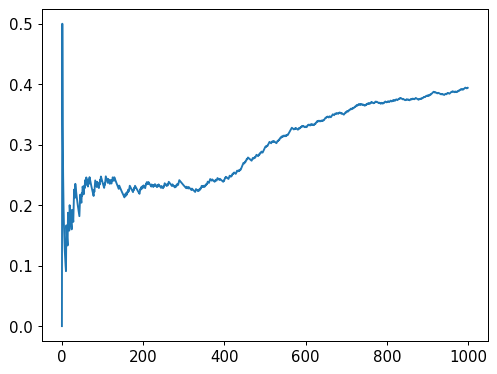

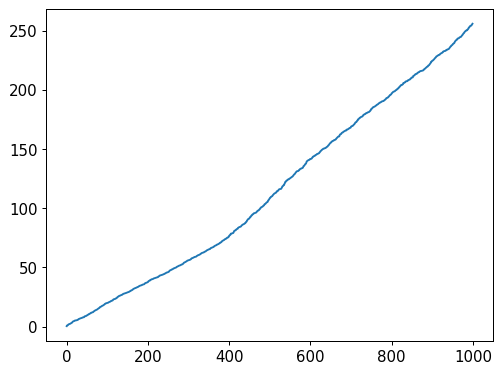

In [11]:
# Fuzzy logic based algorithm implementation
"""
Algorithm based on work done by Minhas et al. (2009)

Minhas, M. R., Gopalakrishnan, S., & Leung, V. C. M. (2009). Multiobjective Routing for Simultaneously Optimizing System Lifetime and Source-to-Sink Delay in Wireless Sensor Networks. 2009 29th IEEE International Conference on Distributed Computing Systems Workshops (p. 123-129). IEEE. 10.1109/ICDCSW.2009.83

"""

import random
import matplotlib.pyplot as plt
import math
import heapq

# edge l = 2m

# Network environment settings
#constants used in energy calculation
# transmission_energy_cost = 45
number_of_episodes = 1000
EPISODES = number_of_episodes
PROBABILITY_OF_PACKET_LOST = 1.0 # Blackhole attack

#define the shape of the environment (i.e., its states)
environment_rows = 10
environment_columns = 10

transmission_energy_cost = 0.007    # the amount of energy(mJ) consumed by a node to receive and forward a packet to 1 hop distance
active_mode_energy_cost = 0.0005    #the amount of energy(mj) cosumed by a node for being in active mode
initial_node_energy = 0.7

num_malicious_rows = 8
fuzzyMaliciousNodes = {} # comment out nodes for different tests
fuzzyMaliciousNodes[(1, 5)] = 0
fuzzyMaliciousNodes[(1, 3)] = 0
fuzzyMaliciousNodes[(2, 1)] = 0
fuzzyMaliciousNodes[(2, 6)] = 0
fuzzyMaliciousNodes[(3, 2)] = 0
fuzzyMaliciousNodes[(3, 5)] = 0
fuzzyMaliciousNodes[(4, 3)] = 0
fuzzyMaliciousNodes[(4, 6)] = 0
fuzzyMaliciousNodes[(5, 2)] = 0
fuzzyMaliciousNodes[(6, 5)] = 0
fuzzyMaliciousNodes[(6, 7)] = 0
fuzzyMaliciousNodes[(7, 8)] = 0
fuzzyMaliciousNodes[(7, 7)] = 0
fuzzyMaliciousNodes[(8, 3)] = 0
fuzzyMaliciousNodes[(8, 1)] = 0




maliciousNodesKeys = fuzzyMaliciousNodes.keys()

####### No need to change #######################

COLUMNS = 10
ROWS = 10
NUMBER_OF_NODES = COLUMNS * ROWS
RADIO_DIST = 1


fuzzy_delivery_rate = []
fuzzy_energy_consumption = []
fuzzy_total_consumption = []

package_dropped = 0
sent_packet_count = 0
lifetime = []
path_lenght = 0

#-----SIMULATION SET UP-------

nodes = [] # [(x-coordinate, y-coordinate), ...]

edges = [] # [(from_node, to_node, distance), ...]
# node = (x-coordinate, y-coordinate)

node_to_energy = {} # key = node (x-coordinate, y-coordinate). Value = residual energy of node

node_to_maximum_path = {} # key = node (x-coordinate, y-coordinate). Value = maximum path to sink node


def create_network():

    for y in range(0, 10):
        for x in range(0,10):
            nodes.append((x, y))
            # node_to_energy[(x, y)] = random.uniform(initial_node_energy, ENERGY)
            node_to_energy[(x, y)] = initial_node_energy

create_network()


def create_edges(edges, nodes, max_radio_distance):
    for node_one in nodes:
        for node_two in nodes:

            if node_one != node_two:
                x_dist = (node_two[0] - node_one[0])**2
                y_dist = (node_two[1] - node_one[1])**2
                x_y_diff = x_dist + y_dist
                distance = math.sqrt(x_y_diff)

                if distance <= max_radio_distance:
                    edges.append((node_one, node_two, distance))


create_edges(edges=edges, nodes=nodes, max_radio_distance=RADIO_DIST)

#-----SIMULATION SET UP END-------


def reception_cost():
    return 0 # No cost of reception

#constants used in fuzzy lifetime membership function
ALPHA = 0.2
GAMMA = 0.9
BETA = 0.2
SIGMA = initial_node_energy
THETA = [0.2, 0.8]

# Equation 6, Fuzzy lifetime membership function
def lifetime_membership_eq6(residual_energy):
    current_energy = residual_energy - transmission_energy_cost

    if (ALPHA * SIGMA) < current_energy and current_energy <= SIGMA:
        return 1 - ((1 - GAMMA) / (1 - ALPHA)) * (1 - current_energy / SIGMA)

    elif transmission_energy_cost < current_energy and current_energy <= (ALPHA * SIGMA):

        condition_1 = (GAMMA) / (ALPHA * (SIGMA - transmission_energy_cost))
        condition_2 = current_energy - transmission_energy_cost
        return condition_1 * condition_2

    elif current_energy <= transmission_energy_cost:
        return 0
    else:
        return 1 # Sink node


# Equation 7, fuzzy membership minimun delay
def minimum_delay_eq7(node):
    return 1 + (((THETA[1] - 1) * node_to_maximum_path[node]) / max(node_to_maximum_path.values())) # THETA can change based on test runs


# The network is at risk of not proiritizing lifetime that shortest path sometimes
# Equation 10, mulitobjective membership function
def multi_objective_membership_eq10(umd, ulf):
    return (BETA * min(umd, ulf)) + ((1 - BETA) * ((umd + ulf) / 2))


# Equation 11, returns new value of weight of edge
def weight_assign_eq11(edge):
    residual_energy = node_to_energy[edge[1]]
    return 1 - multi_objective_membership_eq10(lifetime_membership_eq6(residual_energy), minimum_delay_eq7(edge[1]))


def create_source_nodes_list(routes):
    for _ in range(0, EPISODES):

        index = random.randint(0, len(nodes) - 2)
        routes.append(nodes[index])


def get_shortest_path(edge_list, start_node, end_node):

    #dictionairy where key = a node and value is the previous node when calc dijkstras
    path_nodes = {}
    path_nodes[end_node] = None

    distances = {node: float('inf') for node,_,_ in edge_list}
    distances[start_node] = 0

    unvisited_known_nodes = [(0, start_node)]
    heapq.heapify(unvisited_known_nodes)

    while unvisited_known_nodes:

        (curr_dist, curr_node) = heapq.heappop(unvisited_known_nodes)

        #stop if visiting end_node
        if curr_node == end_node:
            break

        for (from_node, to_node, w) in edge_list:
            if from_node == curr_node:
                new_dist = curr_dist + edge_list[(from_node, to_node, w)]

                if new_dist < distances[to_node]:

                    distances[to_node] = new_dist

                    path_nodes[to_node] = from_node
                    heapq.heappush(unvisited_known_nodes, (new_dist, to_node))

    # Creates a list of the nodes between start_node and end_node
    path = []

    node = end_node
    while node != start_node:
        path.append(node)
        #just in case there is no path between nodes the loop stops if the previous value is None

        if path_nodes[node] is not None:
            node = path_nodes[node]
        else:
            break

    path.append(start_node)
    path.reverse()

    return path


def send_data_and_compute_new_energy(path, fuzzy_total_network_lifetime):
    global package_dropped
    path_lenght = 0

    for index, current_node in enumerate(path):
        # add one step to path lenght

        path_lenght += 1
        fuzzy_total_network_lifetime += 1

        # if the energy level of any node is zero or less, it means that the node is died
        for node in node_to_energy:
            if node_to_energy[node] <= 0:
                lifetime.append(fuzzy_total_network_lifetime)

        for node in node_to_energy: # Remove energy from all nodes.
            node_to_energy[node] = node_to_energy[node] - active_mode_energy_cost

        if index == len(path) - 1:

            return fuzzy_total_network_lifetime

        if current_node in maliciousNodesKeys:
            # Blackhole Attack
            package_dropped = package_dropped + 1
            return fuzzy_total_network_lifetime

            # Selective Forwarding Attack
            # if random.random() < PROBABILITY_OF_PACKET_LOST:
            #     package_dropped = package_dropped + 1
            #     return fuzzy_total_network_lifetime


        current_energy = node_to_energy[current_node]

        if index == 0:
            # Do Only transmission on first node
            node_to_energy[current_node] = current_energy - transmission_energy_cost
            continue

        # Send data
        node_to_energy[current_node] = current_energy - transmission_energy_cost - reception_cost()
    return fuzzy_total_network_lifetime


def shortest_distance_to_sink(edge_list, start_node, end_node):
    distances = {node: float('inf') for node,_,_ in edge_list}
    distances[start_node] = 0

    unvisited_known_nodes = [(0, start_node)]
    heapq.heapify(unvisited_known_nodes)

    while unvisited_known_nodes: # change name

        (curr_dist, curr_node) = heapq.heappop(unvisited_known_nodes)

        #stop if visiting end_node
        if curr_node == end_node:
            break

        for (from_node, to_node, w) in edge_list:
            if from_node == curr_node:
                new_dist = curr_dist + w

                if new_dist < distances[to_node]:

                    distances[to_node] = new_dist
                    heapq.heappush(unvisited_known_nodes, (new_dist, to_node))

    return distances[end_node]


def calculate_distances_to_sink(end_node_input):
    for node in nodes:
        node_to_maximum_path[node] = shortest_distance_to_sink(edge_list=edges, start_node=node, end_node=end_node_input)


def generate_sink_node():
    # ix = random.randint(0, NUMBER_OF_NODES - 1)
    return nodes[NUMBER_OF_NODES - 1]

def calculate_energy_consumption():
    energy_left = sum(node_to_energy.values())
    return (initial_node_energy * NUMBER_OF_NODES) - energy_left


def main():
    #dict with edge - weight in this context
    edge_weight = {} # Key = edge, value = weight

    # Initialize routing requests
    routing_request = []
    create_source_nodes_list(routing_request)

    global sent_packet_count
    global fuzzy_total_network_lifetime
    fuzzy_total_network_lifetime = 0

    ix = 0 # Counter for terminal window

    for request in routing_request: # Iterate for different source nodes
        sent_packet_count = sent_packet_count + 1

        if ix % 10 == 0:
            print(ix)
        ix = ix + 1

        sink_node = generate_sink_node()

        calculate_distances_to_sink(sink_node)

        for _, edge in enumerate(edges):

            #assign weight to edges and add to dict
            edge_weight[edge] = weight_assign_eq11(edge)

        minimum_weight_path = get_shortest_path(edge_weight, request, sink_node)

        if len(minimum_weight_path) == 1:
            fuzzy_delivery_rate.append((sent_packet_count - package_dropped) / sent_packet_count)
            fuzzy_energy_consumption.append(calculate_energy_consumption())
            continue
        else:
            fuzzy_total_network_lifetime = send_data_and_compute_new_energy(minimum_weight_path, fuzzy_total_network_lifetime)

        fuzzy_delivery_rate.append((sent_packet_count - package_dropped) / sent_packet_count)
        fuzzy_energy_consumption.append(calculate_energy_consumption())

        # for node in node_to_energy:
        #     if node_to_energy[node] <= 0:
        #         return sent_packet_count
        if sent_packet_count == number_of_episodes:
          return sent_packet_count

    return sent_packet_count


if __name__ == '__main__':

    global fuzzy_packets_sent
    global fuzzy_packets_delivered
    global fuzzy_packets_dropped
    global fuzzy_total_energy_consumed
    global fuzzy_energy_efficiency
    global fuzzy_lifetime

    fuzzy_packets_sent = main()
    fuzzy_packets_delivered = sent_packet_count - package_dropped
    fuzzy_total_energy_consumed = calculate_energy_consumption()
    fuzzy_energy_efficiency = (sent_packet_count - package_dropped) / calculate_energy_consumption()
    if len(lifetime) == 0:
      lifetime.append(fuzzy_total_network_lifetime)

    if len(lifetime) == 0:
      lifetime.append(fuzzy_total_network_lifetime)
    fuzzy_lifetime = lifetime[0]

    print('Fuzzy Training complete!')
    print("Packages sent: ", fuzzy_packets_sent)
    print("Packages delivered: ", fuzzy_packets_delivered)
    print("Delivery rate: ", fuzzy_packets_delivered / EPISODES)
    print("Dropped packages: ", package_dropped)
    print("Energy consumption: ", calculate_energy_consumption())
    print("Energy efficiency: ", (sent_packet_count - package_dropped) / calculate_energy_consumption())
    print("Network Lifetime: ", fuzzy_lifetime)


    life = []
    for x in range(0, sent_packet_count):
        life.append(x)

    print("NODES")
    for i, node in enumerate(node_to_energy):
        print(node, node_to_energy[node])

    # Uncomment to see plots

    # DELIVERY RATE
    plt.plot(life, fuzzy_delivery_rate)
    plt.show()

    # ENERGY CONSUMPTION
    plt.plot(life, fuzzy_energy_consumption)
    plt.show()

# packet_delivery , t_energy, alive_node = Thesis_approach()
# delivery , energy, alive_node3 = R2LTO()
# delivery2 , energy2, alive_node4 = RLBR()

In [12]:
print(fuzzy_packets_delivered)
print(len(fuzzy_delivery_rate))
print(len(fuzzy_energy_consumption))

394
1000
1000


start energy for nodes: 
(x, y): (0, 0)   0.7
(x, y): (0, 1)   0.7
(x, y): (0, 2)   0.7
(x, y): (0, 3)   0.7
(x, y): (0, 4)   0.7
(x, y): (0, 5)   0.7
(x, y): (0, 6)   0.7
(x, y): (0, 7)   0.7
(x, y): (0, 8)   0.7
(x, y): (0, 9)   0.7
(x, y): (1, 0)   0.7
(x, y): (1, 1)   0.7
(x, y): (1, 2)   0.7
(x, y): (1, 3)   0.7
(x, y): (1, 4)   0.7
(x, y): (1, 5)   0.7
(x, y): (1, 6)   0.7
(x, y): (1, 7)   0.7
(x, y): (1, 8)   0.7
(x, y): (1, 9)   0.7
(x, y): (2, 0)   0.7
(x, y): (2, 1)   0.7
(x, y): (2, 2)   0.7
(x, y): (2, 3)   0.7
(x, y): (2, 4)   0.7
(x, y): (2, 5)   0.7
(x, y): (2, 6)   0.7
(x, y): (2, 7)   0.7
(x, y): (2, 8)   0.7
(x, y): (2, 9)   0.7
(x, y): (3, 0)   0.7
(x, y): (3, 1)   0.7
(x, y): (3, 2)   0.7
(x, y): (3, 3)   0.7
(x, y): (3, 4)   0.7
(x, y): (3, 5)   0.7
(x, y): (3, 6)   0.7
(x, y): (3, 7)   0.7
(x, y): (3, 8)   0.7
(x, y): (3, 9)   0.7
(x, y): (4, 0)   0.7
(x, y): (4, 1)   0.7
(x, y): (4, 2)   0.7
(x, y): (4, 3)   0.7
(x, y): (4, 4)   0.7
(x, y): (4, 5)   0.7
(x, y): (

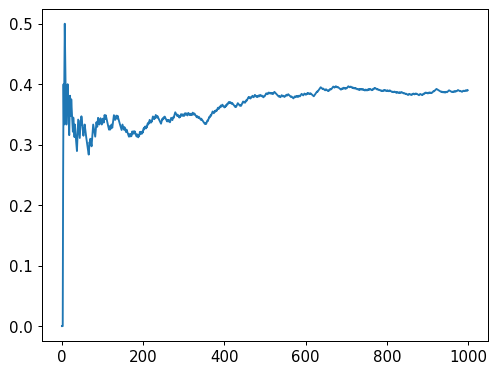

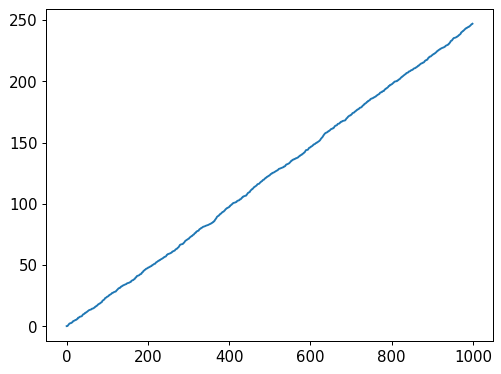

In [24]:
"""
Algorithm based on work done by Cota-Ruiz et al. (2016).

Cota-Ruiz, J., Rivas-Perea, P., Sifuentes, E., & Gonzalez-Landaeta, R. (2016). A recursive shortest path routing algorithm with application for wireless sensor network localization. IEEE Sensors Journal, 16(11), 4631-4637. https://doi.org/10.1109/JSEN.2016.2543680.

"""

import copy
import random
import matplotlib.pyplot as plt

environment_rows = 10
environment_columns = 10

NUMBER_OF_NODES = environment_columns * environment_rows

NUMBER_OF_EPISODES = 1000
transmission_energy_cost = 0.007    # the amount of energy(mJ) consumed by a node to receive and forward a packet to 1 hop distance
active_mode_energy_cost = 0.0005    #the amount of energy(mj) cosumed by a node for being in active mode
initial_node_energy = 0.7
MAX_RADIO_DISTANCE = 1

# lifetime = 0

RSPAR_delivery_rate = []
RSPAR_energy_consumption = []
RSPAR_total_consumption = []

package_dropped = 0
sent_packet_count = 0
lifetime = []
path_lenght = 0


num_malicious_rows = 8
fuzzyMaliciousNodes = {} # comment out nodes for different tests


nodes_dictionairy = {} #Tuple coordinate (x, y) is key, full node is value
node_to_energy = {}


class Node:

    def __init__(self, pos_x, pos_y):
        self.x = pos_x
        self.y = pos_y
        self.neighbors = []
        self.energy = initial_node_energy
        self.rank = 0

    def set_energy(self, energy):
        self.energy = energy

    def add_neighbor(self, new_neighbor):
        if new_neighbor not in self.neighbors:
            self.neighbors.append(new_neighbor)

    def get_neighbors(self):
        return self.neighbors

    def get_position(self):
        return (self.x, self.y)

    def __eq__(self, other):
        if isinstance(other, Node):
            return (self.x, self.y) == (other.x, other.y)
        return NotImplemented

    def __hash__(self):
        return hash(repr(self))

    def __str__(self):
        return "(x, y): {}".format((self.x, self.y))

    def __repr__(self):
        return "(x, y): {}".format((self.x, self.y))

    def print_node(self):
        print("(x, y): {} \nenergy: {} \nrank: {}".format((self.x, self.y), self.energy, self.rank))
        neighbor_string = "Neighbors:"
        for neighbor in self.neighbors:
            neighbor_string += (" " + str(neighbor.get_position()))
        print(neighbor_string)
        print()

fuzzyMaliciousNodes[Node(1, 5)] = 0
fuzzyMaliciousNodes[Node(1, 3)] = 0
fuzzyMaliciousNodes[Node(2, 1)] = 0
fuzzyMaliciousNodes[Node(2, 6)] = 0
fuzzyMaliciousNodes[Node(3, 2)] = 0
fuzzyMaliciousNodes[Node(3, 5)] = 0
fuzzyMaliciousNodes[Node(4, 3)] = 0
fuzzyMaliciousNodes[Node(4, 6)] = 0
fuzzyMaliciousNodes[Node(5, 2)] = 0
fuzzyMaliciousNodes[Node(6, 5)] = 0
fuzzyMaliciousNodes[Node(6, 7)] = 0
fuzzyMaliciousNodes[Node(7, 8)] = 0
fuzzyMaliciousNodes[Node(7, 7)] = 0
fuzzyMaliciousNodes[Node(8, 3)] = 0
fuzzyMaliciousNodes[Node(8, 1)] = 0

malicoius_nodes = fuzzyMaliciousNodes.keys()

def create_nodes():
    for x in range(environment_rows):
        for y in range(environment_columns):
            node = Node(x, y)
            # init node energy for all created nodes in node list
            node_to_energy[node] = initial_node_energy
            nodes_dictionairy[(x, y)] = node


def make_neighbors():
    for x in range(environment_rows):
        for y in range(environment_columns):

            if x > 0:
                nodes_dictionairy[(x, y)].add_neighbor(nodes_dictionairy[((x - 1), y)])
            if x < environment_rows - 1:
                nodes_dictionairy[(x, y)].add_neighbor(nodes_dictionairy[((x + 1), y)])
            if y > 0:
                nodes_dictionairy[(x, y)].add_neighbor(nodes_dictionairy[(x, (y - 1))])
            if y < environment_columns - 1:
                nodes_dictionairy[(x, y)].add_neighbor(nodes_dictionairy[(x, (y + 1))])

# STATIC
seq = []

def get_number_of_hops(source_node, hops):
    global c
    global seq

    neighbors = source_node.get_neighbors()

    for index, node in enumerate(neighbors):

        if hops[neighbors[index]] == 0:
            hops[neighbors[index]] = hops[source_node] + 1

        elif (hops[neighbors[index]] - hops[source_node]) <= 1:
            continue

        elif hops[neighbors[index]] < (hops[source_node] - 1):
            hops[source_node] = hops[neighbors[index]] + 1

        else:
            hops[neighbors[index]] = hops[source_node] + 1

            if (max_of_hops(neighbors=neighbors, hops=hops)[1] - hops[neighbors[index]]) > 1:

                get_number_of_hops(neighbors[index], hops)

    if source_node in seq:
        return

    else:
        seq.append(source_node)

    for index, node in enumerate(neighbors):
        get_number_of_hops(neighbors[index], hops)


shortest_path = []


def get_shortest_paths(hops, neighbors, hop_number, paths, sink_node, org_sink):
    global shortest_path
    hop_number -= 1

    for i in range(hop_number + 1):
        for index, node in enumerate(neighbors):

            if hops[neighbors[index]] == (hop_number - i):

                paths[hop_number - i] = neighbors[index]

                get_shortest_paths(hops, node.get_neighbors(), hop_number - i, paths, node, org_sink)

            if (hop_number - i) == 1 and i == 0:
                temp_paths = [node for node in paths if node != None]


                if len(temp_paths) == hops[org_sink]:
                    shortest_path.append(temp_paths)


# returns distance of neighbor with max distance from source node
def max_of_hops(neighbors, hops):
    max_distance = 0
    neighbor_list = []

    for neighbor in neighbors:
        neighbor_of_neigbhors = neighbor.get_neighbors()

        for neighbor_two in neighbor_of_neigbhors:

            if neighbor_two not in neighbor_list:
                neighbor_list.append(neighbor_two)

            if max_distance < hops[neighbor_two]:
                max_distance = hops[neighbor_two]

    return (neighbor_list, max_distance)


def __init__():
    create_nodes()
    make_neighbors()


def find_shortest_path(sink_node, source_node):
    global shortest_path
    global seq

    shortest_path = []
    seq = []

    hops = {x: 0 for x in copy.deepcopy(list(nodes_dictionairy.values()))}

    get_number_of_hops(nodes_dictionairy[source_node], hops)
    hops[nodes_dictionairy[source_node]] = 0

    p = [None] * (hops[sink_node])
    get_shortest_paths(hops, sink_node.get_neighbors(), hops[sink_node], p, sink_node, sink_node)


def print_shortest_path(shortest_path):
    for x in shortest_path:
        for y in x:
            print(y)

        print("--")


def create_grid(rows, columns, nodes, hop):
    grid = [[0]*columns for _ in range(rows)]

    for i in range(rows):
        for j in range(columns):

            if (i, j) in nodes:
                node = nodes_dictionairy[(i, j)]
                grid[i][j] = hop[node]

    return(grid)


def send_data_along_path(path, total_lifetime):
    global lifetime
    global package_dropped

    if len(path) > 1:

        for node in path:
            total_lifetime += 1

            check_for_dead_nodes(total_lifetime)
            drain_active_energy_off_nodes()

            # lifetime.append(total_lifetime)
            # lifetime += 1
            if node in malicoius_nodes:
                package_dropped += 1
                return total_lifetime

            node_to_energy[node] -= transmission_energy_cost

    else: #Only one node in path.

        total_lifetime += 1

        check_for_dead_nodes(total_lifetime)
        drain_active_energy_off_nodes()

        if path[0] in malicoius_nodes:
            package_dropped += 1
            return total_lifetime

        node_to_energy[path[0]] -= transmission_energy_cost

    return total_lifetime


def check_for_dead_nodes(total_lifetime):
    for node in node_to_energy:
            if node_to_energy[node] <= 0:
                lifetime.append(total_lifetime)


def drain_active_energy_off_nodes():
    for node in node_to_energy:
        node_to_energy[node] -= active_mode_energy_cost


def calculate_energy_consumption():
    energy_left = sum(node_to_energy.values())
    return (initial_node_energy * NUMBER_OF_NODES) - energy_left


def main():
    global shortest_path
    global recursive_total_lifetime
    global sent_packet_count

    recursive_total_lifetime = 0
    __init__()

    sink_node = nodes_dictionairy[(9, 9)]

    print("start energy for nodes: ")
    for node in node_to_energy:
        print(node, " ", node_to_energy[node])

    for x in range(0, NUMBER_OF_EPISODES):

        sent_packet_count += 1

        print(x)
        while(True):
            x = random.randint(0, environment_rows - 1)
            y = random.randint(0, environment_columns - 1)
            source_node = (x, y)

            if not source_node == sink_node:
                break

        find_shortest_path(sink_node=sink_node, source_node=source_node)
        # print_shortest_path(shortest_path)

        ix = 0
        if len(shortest_path) >= 1:
            ix = random.randint(0, len(shortest_path) - 1)
            recursive_total_lifetime = send_data_along_path(shortest_path[ix], recursive_total_lifetime)

        else: # If source node is one hop away from sink
            recursive_total_lifetime = send_data_along_path([nodes_dictionairy[source_node]], recursive_total_lifetime)

        RSPAR_delivery_rate.append((sent_packet_count - package_dropped) / sent_packet_count)
        RSPAR_energy_consumption.append(calculate_energy_consumption())

        if sent_packet_count == NUMBER_OF_EPISODES:
            return sent_packet_count

    return sent_packet_count


if __name__ == '__main__':

    recursive_packets_sent = main()
    recursive_delievered = sent_packet_count - package_dropped
    total_energy_consumption = calculate_energy_consumption()

    if len(lifetime) == 0:
        lifetime.append(recursive_total_lifetime)

    if len(lifetime) == 0:
        lifetime.append(recursive_total_lifetime)

    recursive_lifetime = lifetime[0]

    print("Recursive training complete")
    print("Packages sent: ", recursive_packets_sent)
    print("Packages delivered: ", recursive_delievered)
    print("Delivery rate: ", recursive_delievered / NUMBER_OF_EPISODES)
    print("Dropped packages: ", package_dropped)
    print("Energy consumption: ", total_energy_consumption)
    print("Energy efficiency: ", (sent_packet_count - package_dropped) / total_energy_consumption)
    print("Network Lifetime: ", recursive_lifetime)

    life = []
    for x in range(0, sent_packet_count):
        life.append(x)


    print("end energy for nodes: ")
    for node in node_to_energy:
        print(node, " ", node_to_energy[node])

    # DELIVERY RATE
    plt.plot(life, RSPAR_delivery_rate)
    plt.show()

    # ENERGY CONSUMPTION
    plt.plot(life, RSPAR_energy_consumption)
    plt.show()

In [7]:

# functions and parameters for RLBEEP algorithm
MND_lon, MND_lat = environment_rows, environment_columns
DFR_min = 5
DFR_max = 55
sleep_counter = np.zeros((environment_rows, environment_columns), dtype=int)
sleep_thresh = 5

def get_distance(row1, col1, row2, col2):
    return np.sqrt((row1 - row2) ** 2 + (col1 - col2) ** 2)

def get_normalized_distance(row1, col1, row2, col2):
    return get_distance(row1, col1, row2, col2) / max(MND_lon, MND_lat)

# get n
def get_n(row1, col1, row2, col2):
    normalized_distance = get_normalized_distance(row1, col1, row2, col2)
    return (normalized_distance * (DFR_max - DFR_min)) + DFR_min


#
def restrict_data_transmission(prev_min, prev_max, sensor_data, threshold):
    curr_min = min(prev_min, sensor_data)
    curr_max = max(prev_max, sensor_data)
    send_permit = bool(abs(curr_max - sensor_data) > threshold or abs(sensor_data - curr_min) > threshold)
    return send_permit, curr_min, curr_max


#
def sleep_scheduling(row, col, send_permit, sleep_thresh, sleep_counter):
    if send_permit:
        sleep_counter[row, col] = 0
    else:
        sleep_counter[row, col] += 1

    if sleep_counter[row, col] > sleep_thresh:
        return 'sleep'
    else:
        return 'active'


def check_sleep_mode(row, col):
    if sleep_counter[row, col] > sleep_thresh:
        return 'sleep'
    else:
        return 'active'


#
def RLBEEP(epsilone=0, discount_factor=0.2, learning_rate=0.9):
    env = WSN(Q=q_values4)

    packet_delivery = []
    t_energy = []
    alive = []
    lifetime = []
    total_network_lifetime = 0

    path_lenght = 0
    nb_success = 0
    total_energy = 0
    # hop = 0

    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)

    # run through 1000 training episodes
    for episode in range(number_of_episodes):
        # get the starting location for this episode
        row_index, column_index = env.get_starting_location()

        alive_node = environment_rows * environment_columns

        # initialize the consumed energy to zero for the curretn episode
        energy = 0
        path_lenght = 0

        prev_min = float('inf')
        prev_max = -float('inf')

        # continue taking actions (i.e., moving) until we reach a terminal state
        # (i.e., until we reach the item packaging area or crash into an item storage location)
        while not env.is_terminal_state(row_index, column_index):
            data_transmission_threshold = 3
            # mock temperature sensor data (random.randint(-10, 40))
            send_permit, prev_min, prev_max = restrict_data_transmission(prev_min, prev_max, random.randint(-10, 40),
                                                                         data_transmission_threshold)
            node_state = sleep_scheduling(row_index, column_index, send_permit, sleep_thresh=sleep_thresh,
                                          sleep_counter=sleep_counter)

            if node_state == 'active':
                # choose which action to take (i.e., where to move next)
                action_index = env.get_next_action(row_index, column_index, epsilone)

                # perform the chosen action, and transition to the next state (i.e., move to the next location)
                old_row_index, old_column_index = row_index, column_index  # store the old row and column indexes
                row_index, column_index = env.get_next_location(row_index, column_index, action_index)

                # calculate the reward for moving to the new state
                reward = env.get_reward(row_index, column_index)
                # calculate the remaining number of hops needed to reach the destination node
                hop = 18 - row_index - column_index
                # represents the energy reward for moving to the next state (location) in the reinforcement learning algorithm.
                d = get_distance(row_index, column_index, old_row_index, old_column_index)
                R = initial_energy[row_index, column_index] / ((hop + 1) * (9 ** get_n(row_index, column_index, old_row_index, old_column_index)))

                old_q_value = q_values4[old_row_index, old_column_index, action_index]
                temporal_difference = R + (discount_factor * np.max(q_values4[row_index, column_index])) - old_q_value

                # update the Q-value for the previous state and action pair
                new_q_value = old_q_value + (learning_rate * temporal_difference)
                q_values4[old_row_index, old_column_index, action_index] = new_q_value

                # update the energy level of all node (node consume energy if turn on active mode)

                initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

                # add one step to path lenght
                path_lenght += 1
                # add one step to total network lifetime
                total_network_lifetime += 1

                # if the energy level of any node is zero or less, it means that the node is died
                for row in range(environment_rows):
                    for column in range(environment_columns):
                        if check_sleep_mode(row, column) == 'sleep':
                            initial_energy[row, column] -= sleep_mode_energy_cost
                        else:
                            initial_energy[row, column] -= active_mode_energy_cost

                        if initial_energy[row, column] <= 0:
                            lifetime.append(total_network_lifetime)

                # If we have a reward, it means that our outcome is a success
                if reward == 1:
                    nb_success += 1

                if initial_energy[row_index, column_index] <= 0:
                    alive_node -= 1

            else:
                alive_node -= 1

        alive.append(alive_node)
        packet_delivery.append(nb_success / (episode + 1))

        sleep_count_num = 0
        for row in range(environment_rows):
            for column in range(environment_columns):
                if check_sleep_mode(row, column) == 'sleep':
                    sleep_count_num += 1

        energy = path_lenght * transmission_energy_cost + (100 - sleep_count_num) * path_lenght * active_mode_energy_cost + sleep_count_num * sleep_mode_energy_cost

        total_energy += energy
        t_energy.append(total_energy)

    if len(lifetime) == 0:
        lifetime.append(1000)

    life = []
    for x in range(number_of_episodes):
        life.append(x)

    print('RLBEEP Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / episode)
    print("Energy : ", total_energy)
    print("Energy efficiency: ", nb_success / total_energy)

    return packet_delivery, t_energy, alive

delivery4 , energy4, alive_node4 = RLBEEP()

RLBEEP Training complete!
number of packet delivered: 8
delivery rate:  0.008008008008008008
Energy :  374.66100000000057
Energy efficiency:  0.02135263611638251


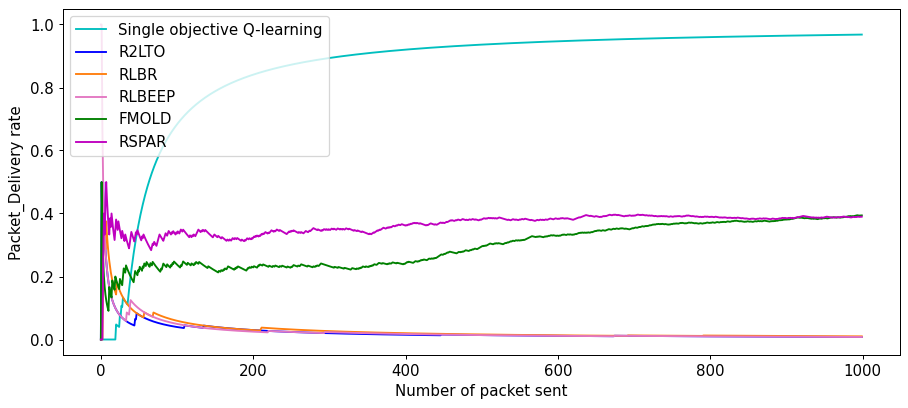

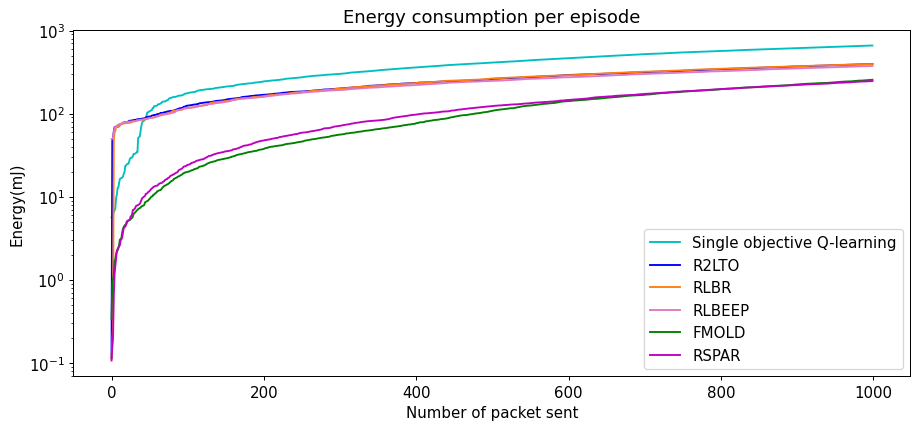

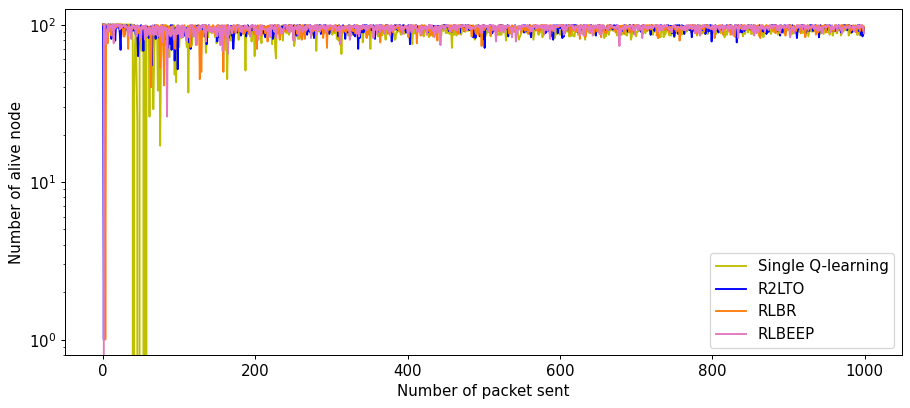

In [25]:
# Plot the result of two methods
x = range(len(delivery1))
plt.figure(figsize=(12, 5))
# plt.plot(x, delivery6, color='r', label='Proposed')
plt.plot(x, delivery1, color='c', label='Single objective Q-learning')
plt.plot(x, delivery2, color='b', label='R2LTO')
plt.plot(x, delivery3, color='tab:orange', label='RLBR')
plt.plot(x, delivery4, color='tab:pink', label='RLBEEP')
plt.plot(x, fuzzy_delivery_rate, color='g', label='FMOLD')
plt.plot(x, RSPAR_delivery_rate, color='m', label='RSPAR')
plt.xlabel("Number of packet sent")
plt.ylabel("Packet_Delivery rate")
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
#plt.title("Comparing Epsilon")
plt.show()

x2 = range(len(energy1))
plt.figure(figsize=(12, 5))
# plt.plot(x, energy6, color='r', label='Proposed')
plt.plot(x2, energy1, color='c', label='Single objective Q-learning')
plt.plot(x2, energy2, color='b', label='R2LTO')
plt.plot(x2, energy3, color='tab:orange', label='RLBR')
plt.plot(x2, energy4, color='tab:pink', label='RLBEEP')
plt.plot(x, fuzzy_energy_consumption, color='g', label='FMOLD')
plt.plot(x, RSPAR_energy_consumption, color='m', label='RSPAR')
plt.xlabel("Number of packet sent")
plt.ylabel("Energy(mJ)")
plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.title("Energy consumption per episode")
plt.show()

# Plot networks' lifetime

x = range(len(alive_node1))
plt.figure(figsize=(12, 5))
plt.plot(x, alive_node1, color='y', label='Single Q-learning')
plt.plot(x, alive_node2, color='b', label='R2LTO')
plt.plot(x, alive_node3, color='tab:orange', label='RLBR')
plt.plot(x, alive_node4, color='tab:pink', label='RLBEEP')
plt.xlabel("Number of packet sent")
plt.ylabel("Number of alive node")
plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('w')
plt.legend()
plt.show()

In [36]:
# Q-learning algorithm
def Q_learning_for_deliveryRate(epsilone = 0, discount_factor = 0.2, learning_rate = 0.9):
    env = WSN(Q=q_values1)

    packet_delivery = []
    t_energy = []
    alive = []
    lifetime = []
    total_network_lifetime = 0

    path_lenght = 0
    nb_success = 0
    total_energy = 0

    # define the initial energy of nodes
    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)

    #run through 1000 training episodes
    for episode in range(number_of_episodes):
      print(episode)
      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()

      #initialize the amount of consumed energy to zero for the curretn episode
      energy = 0
      path_lenght = 0
      alive_node = environment_rows * environment_columns

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until the data packet reaches the destination node or stuck wiht a malicious node)
      while not env.is_terminal_state(row_index, column_index):

          #choose which action to take (i.e., where to move next)
          action_index = env.get_next_action(row_index, column_index, epsilone)


          #perform the chosen action, and transition to the next state (i.e., move to the next node)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)

          #receive the reward from SDN for moving to the new state
          reward = env.get_reward(row_index, column_index)

          old_q_value = q_values1[old_row_index, old_column_index, action_index]
          temporal_difference = reward + (discount_factor * np.max(q_values1[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values1[old_row_index, old_column_index, action_index] = new_q_value

          #calculate the current energy-level for all nodes
          initial_energy -= active_mode_energy_cost
          initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

           # add one step to path lenght
          path_lenght += 1
          total_network_lifetime += 1

          # if the energy level of any node is zero or less, it means that the node is died
          for row in range(environment_rows):
            for column in range(environment_columns):
              if initial_energy[row, column] <= 0:
                lifetime.append(total_network_lifetime)

          #if the nergy level of a node is zero or less, it means that node is died
          if initial_energy[row_index, column_index] <= 0:
              alive_node -= 1


          # If we have a reward, it means that our outcome is a success
          if reward == 1:
              nb_success += 1

      alive.append(alive_node)
      packet_delivery.append(nb_success/(episode+1))
      energy = path_lenght*transmission_energy_cost + 100 * path_lenght * active_mode_energy_cost
      total_energy += energy
      t_energy.append(total_energy)

    if len(lifetime) == 0:
      lifetime.append(1000)

    life = []
    for x in range(number_of_episodes):
      life.append(x)

    print('Q-learning Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / episode)
    print("Energy : ", total_energy)
    print("Energy efficiency: ", nb_success / total_energy)

    return(packet_delivery, t_energy, alive)

delivery1 , energy1, alive_node1 = Q_learning_for_deliveryRate()

0


KeyboardInterrupt: 